## Variance Selection 

If we have a Gaussian wavepacket in real space with some width $\sigma_x$

$$

\psi(x) = \frac{1}{\sigma_x\sqrt{2\pi}}e^{-x^2/2\sigma_x^2}

$$

then we have

\begin{align}

\psi(k) &= \frac{1}{\sigma_x\sqrt{2\pi}} \times \sqrt{\pi 2\sigma_x^2}e^{-\pi^2 2 \sigma_r^2 k^2} \\
        &= e^{-k^2/2\sigma_k^2}

\end{align}

where $\sigma_k = \frac{1}{2\pi\sigma_x}$.

If we fix $\sigma_x \approx 1$ bohr, then $\sigma_k \approx \frac{1}{2\pi} \ \mathrm{bohr}^{-1} \approx 0.159 \ \mathrm{bohr}^{-1}$. The momentum space grid spacing from the Deuterium system is $0.39 \ \mathrm{bohr}^{-1}$

Let's look at some Gaussians

In [185]:
import numpy as np

def gaussian_real_space(ns, sigma_r, box_length, mu=0.0):
    nmax = ns[-1]
    x_scaled = ns * (box_length/nmax)
    gx = np.exp(-(x_scaled-mu)**2/2*(sigma_r)**2) / (sigma_r*np.sqrt(2*np.pi))
    return gx

def gaussian_kspace(g_scaled, sigma_k):
    gx = np.exp(-g_scaled**2/(2*sigma_k)**2)
    return gx

In [158]:
import math
L = 15.73 # bohr
ecut = 60 # Ha
ng_max = math.ceil(np.sqrt(2*ecut)/(2*np.pi/L))
if ng_max % 2 == 0:
    ng_max += 1
delta_x = L / ng_max

In [105]:
def get_ngmax(ecut, box_length):
    ng_max = math.ceil(np.sqrt(2*ecut)/(2*np.pi/box_length))
    if ng_max % 2 == 0:
        ng_max += 1
    return ng_max

Text(0.5, 0, 'x')

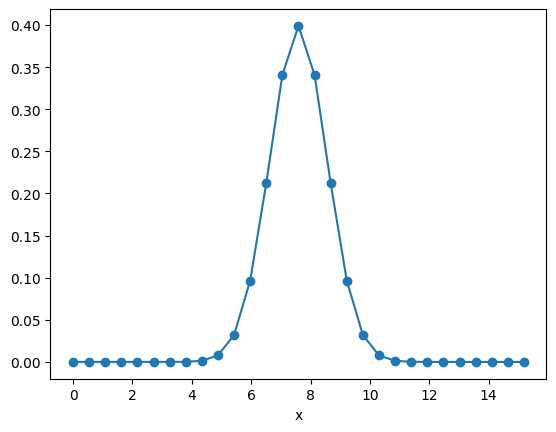

In [187]:
import matplotlib.pyplot as plt
sigma_r = 1.0 # bohr
sigma_k = 1.0 / (2*np.pi*sigma_r)
ns_x = np.arange(0, ng_max)
grid = ns_x * delta_x
gx = gaussian_real_space(ns_x*delta_x, sigma_r, L, mu=L/2.0)
plt.plot(grid, gx, marker='o')
plt.xlabel("x")

0.3994396253769603 0.15915494309189535


Text(0.5, 0, 'k')

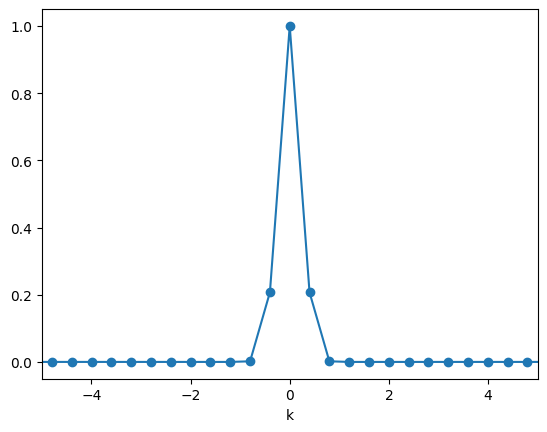

In [161]:
ns_k = np.arange(-ng_max, ng_max)
factor = 2*np.pi/L
gk = gaussian_kspace(ns_k*factor, sigma_k)
plt.plot(ns_k*factor, gk, marker='o')
plt.xlim([-5, 5])
print(factor, sigma_k)
plt.xlabel("k")

Recall we are writing

$$
|\psi\rangle = C\sum_k e^{-k^2/2\sigma_k^2}|k\rangle,
$$

where $\langle x | k\rangle = e^{ikx}/\sqrt{L}$ and $C$ is some normalization constant.

In [178]:
def compute_kinetic_energy(ecut, sigma_k, factor):
    ng_max = math.ceil(np.sqrt(2*ecut)/factor)
    if ng_max % 2 == 0:
        ng_max += 1
    ns_k = np.arange(-ng_max, ng_max)
    factor = 1
    ksquare = 0.5 * (factor**2.0) * ns_k * ns_k
    gk = gaussian_kspace(ns_k*factor, sigma_k)
    kinetic = sum(ksquare * gk)
    return kinetic

## Kinetic Energy Change

We can monitor the convergence of the kinetic energy with the variance of the wavepacket and check when its value converges. From the stopping power numerics we expect the variance of the wavepacket to drop by about 0.04 percent. We can monitor the effect this has on the kinetic energy in the wavepacket as a function of the variance in the gaussian.

We have

$$

\mathrm{KE} = \sum_k k^2 e^{-k^2/(2\sigma_k^2)} \rightarrow \frac{L}{2\pi}\int_{-\infty}^{\infty} dk k^2 e^{-k^2/(2\sigma_k^2)}  


$$

In [231]:
ecut = 400
factor = 1 - 0.0035
L = 15.43
delta_k = 2*np.pi / L

import scipy

for sigma_r in [1, 0.75, 0.5, 0.25, 0.125, 0.0625, 0.0625/2]:
    sigma_k = 1.0 / (2*np.pi*sigma_r)
    ke_init = compute_kinetic_energy(ecut, sigma_k, delta_k)
    ke_fin = compute_kinetic_energy(ecut, sigma_k*factor, delta_k)
    print(sigma_r, sigma_k, (ke_fin-ke_init)/ke_init, ke_fin-ke_init, ke_init/L)

1 0.15915494309189535 -0.06709475132930202 -3.4703543163059014e-06 3.352118354105059e-06
0.75 0.2122065907891938 -0.038313315072795666 -0.00014869549022579953 0.0002515255688571963
0.5 0.3183098861837907 -0.017334442822805704 -0.0014736333522407802 0.005509518292795121
0.25 0.6366197723675814 -0.010464053908504706 -0.00957066773611337 0.05927565268457239
0.125 1.2732395447351628 -0.010463292874999797 -0.07656030759208488 0.47420853011524605
0.0625 2.5464790894703255 -0.01046329287500016 -0.6124824607367003 3.7936682409219693
0.03125 5.092958178940651 -0.01046329287500016 -4.8998596858936025 30.349345927375754


Looks as if we need $\sigma_r \le 0.5$ bohr for the relative change in kinetic energy to plateau, reducing the variance much more starts to lead to a worsening in precision but only at 6th digit or so.

The discretization error (integtral - sum) for $\sigma_k = 0.6366$

We want a 0.1 eV / A error in the stopping power which corresponds to 

In [155]:
from ase.units import Hartree, Bohr

error_au = 0.1 * Bohr / Hartree
print("Error in au: ", error_au)
print((2*np.pi/L)**2, 0.32/0.159)
print(0.21835/0.8095)

Error in au:  0.0019446903957408628
0.17545963379714413 2.0125786163522013
0.2697344039530574


## Wavepackets

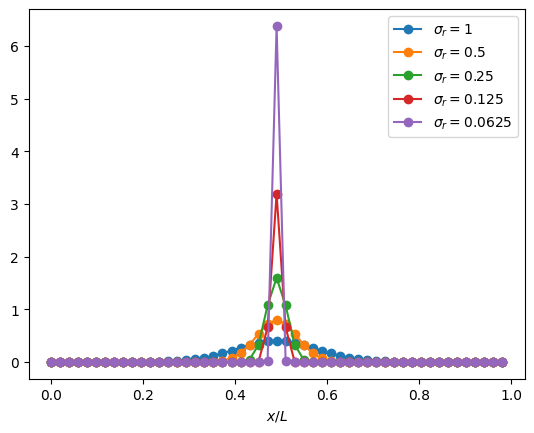

In [131]:
ecut = 100
factor = 1-0.0035
ng_max = get_ngmax(ecut, L)
delta_x = L / ng_max
for sigma_r in [1, 0.5, 0.25, 0.125, 0.0625]:
    ns_x = np.arange(0, ng_max)
    grid = ns_x * delta_x
    gx = gaussian_real_space(grid, sigma_r, L, mu=L/2.0)
    plt.plot(grid/L, gx, marker="o", label=fr"$\sigma_r = ${sigma_r}")
plt.legend()
plt.xlabel("$x/L$")
plt.show()

14.779266138947532


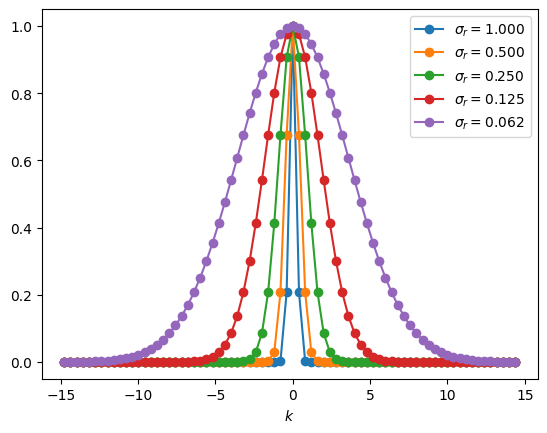

In [111]:
ecut = 100
factor = 1-0.0035
ng_max = get_ngmax(ecut, L)
factor = 2*np.pi/L
print(ng_max*factor)
delta_x = L / ng_max
for sigma_r in [1, 0.5, 0.25, 0.125, 0.0625]:
    sigma_k = 1.0 / (2*np.pi*sigma_r)
    ns_k = np.arange(-ng_max, ng_max)
    gk = gaussian_kspace(ns_k, sigma_k, L)
    plt.plot(ns_k*factor, gk, marker="o", label=fr"$\sigma_r = ${sigma_r:4.3f}")
plt.legend()
plt.xlabel("$k$")
plt.show()


# Gaussian State Preparation

**--Equation Dump--**

Ref [1] outlines how to approximately preparare a 1D Gaussian state

$$

|G(\sigma,\mu)\rangle = \frac{1}{\mathcal{N}} \int dx e^{-\left(\frac{x-\mu}{\sigma}\right)^2} |x\rangle; \quad \mathcal{N}^2 = \sigma \sqrt{2\pi}

$$

which is approximated by a discreted 1DGS (Kitaev-Webb (KW))

$$

|G_{\mathrm{KW}}(\sigma,\mu)\rangle = \sum_{i\in\mathbb{Z}} G_{\mathrm{KW}}(\sigma,\mu;i)|i \rangle

$$

where

$$
G_{\mathrm{KW}}(\sigma,\mu;i) = \frac{1}{f_{\mathrm{KW}(\sigma,\mu)}} e^{\frac{(i-\mu)^2}{4\sigma^2}}, \quad f_{\mathrm{KW}}(\sigma,\mu) = \sum_{i\in\mathbb{Z}} e^{\frac{(i-\mu)^2}{4\sigma^2}}.

$$

In practice, we further approximate 

$$
G_{\mathrm{KW}}(\sigma,\mu,i) \approx \sum_j^{2^m-1}G_{\mathrm{KW}}(\sigma,\mu,i+j2^m).
$$

There are then two approximations: 1) the representation of a Gaussian state defined for continuous values of the position, and 2) the description of this discretized Gaussian using a fixed prescision real numbers, i.e. every real number is associated with a $p$-bit integer. The question is then how to generate this state, and how much do these approximations matter in practice.

From [1], they say the (integer) largest value for a real number is $2^m$, so they use $m$ to be the radix point position (the number of bits to the left of the decimal point).  


In our case we just want to prepare the state

$$

\psi(k) = C e^{-(k-\mu)^2/4\sigma^2}

$$

which can be approximated as


$$

|\psi \rangle = \tilde{C} \sum_n \delta e^{-n^2/(4\tilde{\sigma})^2} |\delta n\rangle

$$

where $k$ is a continuous variable in principle. In practice $k$ lives on a discrete grid given by $[-2\pi n/L, 2\pi/L)$, where $L$ is the size of the supercell, and the range of $n$ is usually fixed by the planewave cutoff, $\frac{1}{2}(k_{\max}-k_{\mathrm{mean}})^2 \le E_{\mathrm{cut}}$, which for us is typically $n \approx 61$, $\delta = 2\pi/L$

[1] suggests two algorithms to generate a Gaussian. The first is a recursive algorithm where the amplitudes $\approx e^{k^2/\sigma^2}$  are prepared on the quantum computer via

$$

|\xi(\sigma, \mu, m)\rangle = |\xi(\sigma/2,\mu/2,m-1)\rangle\otimes|0\rangle + |\xi(\sigma,(\mu-1)/2,m-1\rangle)\otimes|1\rangle, \quad \theta = \arccos\sqrt{\frac{f_{\mathrm{KW}}(\sigma, \mu/2)}{f_{\mathrm{KW}}(\sigma, \mu)}}.

$$

This is problematic because it involves computing $\arccos$ and $f_{\mathrm{KW}}$ on the quantum computer.

The second approach is to use an idea similar to alias sampling described in the linear-T complexity paper. At a high level we can classically compute the amplitudes, load these into a register and probabilistically sample from this distribution such that some uniformly prepared initial state ends up in a correctly weighted state.


[1] https://arxiv.org/pdf/2110.05708.pdf



* Test these classically.
* Cost alias sampling approach (this should be in the PRL).
* Check error given planewave cutoffs we expect and sigma.

In [225]:
import numpy as np
def gaussian(xval, sigma_x):
    return np.exp(-xval**2/(2*sigma_x**2))


# for L in range(2, 20, 2):
#     ng = get_ngmax(100, L)
#     delta_x = L / ng
#     xs = delta_x * np.arange(0, ng+1)
#     integral_approx = np.sum(delta_x * xs**2.0 * gaussian(xs, 1.0))
#     print(L, delta_x, ng, integral_approx)

L = 10
ecut = 100
delta_k = (2 * np.pi) / L
ks = delta_k * np.arange(-ng, ng)
integral_approx = np.sum(delta_k * ks**2.0 * gaussian(ks, 1.0))
print(integral_approx)


2.5066282746310007
